In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
%matplotlib inline

number of car images:  8792 
number of non-car images:  8968
image shape:  (64, 64, 3) 
image date type:  float32


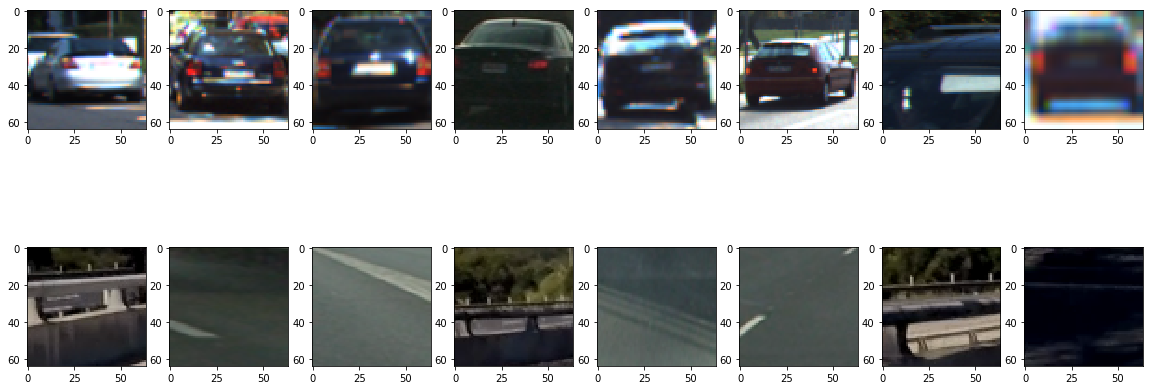

In [2]:
plt.rcParams["figure.figsize"] = (20,8)

##### Load vehicle and non-vehicle images for training
cars = glob.glob('dataset/vehicles/*/*.png')
notcars = glob.glob('dataset/non-vehicles/*/*.png')
print("number of car images: ", len(cars), "\nnumber of non-car images: ", len(notcars))
image = mpimg.imread(cars[0])
print("image shape: ", image.shape, "\nimage date type: ", image.dtype)

##### Randomly show some car images and non-car images
fig = plt.figure()
for i in range(8):
    fig.add_subplot(2,8,i+1)
    image = mpimg.imread(cars[np.random.randint(0,len(cars))])
    plt.imshow(image)
    fig.add_subplot(2,8,i+9)
    image = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
    plt.imshow(image)

/home/yuanzhou/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


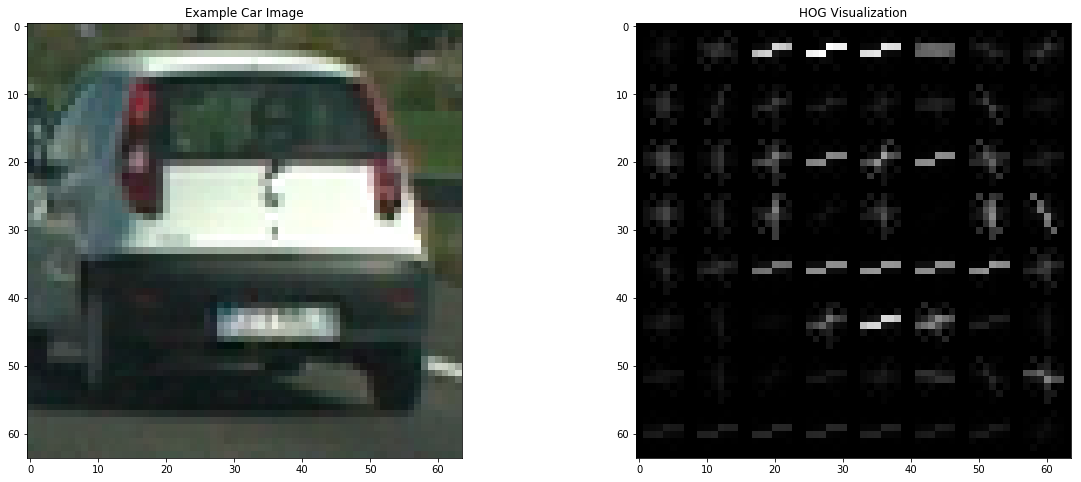

In [3]:
##### Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

##### Visualize HOG on one example image
image = mpimg.imread(cars[0])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray,9,8,2,vis=True, feature_vec=False)
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [4]:
##### Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

##### Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [5]:
##### Define a function to extract (HOG, Binned color, and Color histogram) features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply get_hog_features() to get HOG fetures
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], orient,
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [6]:
# train the model with chosen parameters (the classifier and scaler will be used later)
import pickle

# after many experiment to choose the following parameters
# the choosing should not only based on accuracy (could be overfitting), but the result with the final video.
colorspace = 'YUV'
spatial_size = (16, 16)
hist_bins=16
hist_range=(0,256)
orient = 11
pix_per_cell = 16
cell_per_block = 2

car_features = extract_features(cars, cspace=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

# Create an array stack of feature vectors and normalize
X_origin = np.vstack((car_features, notcar_features)).astype(np.float64)  
X_scaler = StandardScaler().fit(X_origin)
X = X_scaler.transform(X_origin)

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand_state)

# Train and show result
# use smaller C to avoid overfitting
svc = LinearSVC(C=0.0001)
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

pickle.dump(svc, open("svc_model.p", 'wb'))

/home/yuanzhou/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test Accuracy of SVC =  0.988738738739


In [7]:
#import pickle
# load the svc model
#svc = pickle.load(open("svc_model.p", 'rb'))

/home/yuanzhou/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


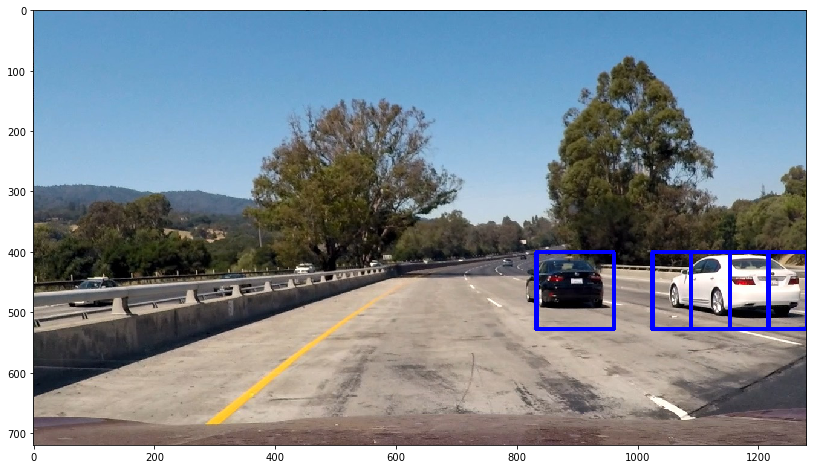

In [7]:
##### Sliding window search vehicles in an image

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to extract features from a single image window
def single_img_features(img, color_space='YUV', spatial_size=(16, 16),
                        hist_bins=16, orient=11, pix_per_cell=16, cell_per_block=2): 
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)      
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins)
    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], orient,
                pix_per_cell, cell_per_block, vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)
    img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return img_features

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YUV',spatial_size=(16, 16), 
                   hist_bins=16, orient=11, pix_per_cell=16, cell_per_block=2):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).astype(np.float64).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# function to draw boxes in an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy


##### test on an image
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)
# this is for png
image = image.astype(np.float32)/255

y_start_stop=[400,None]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YUV',spatial_size=(16, 16), 
                   hist_bins=16, orient=11, pix_per_cell=16, cell_per_block=2)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

/home/yuanzhou/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


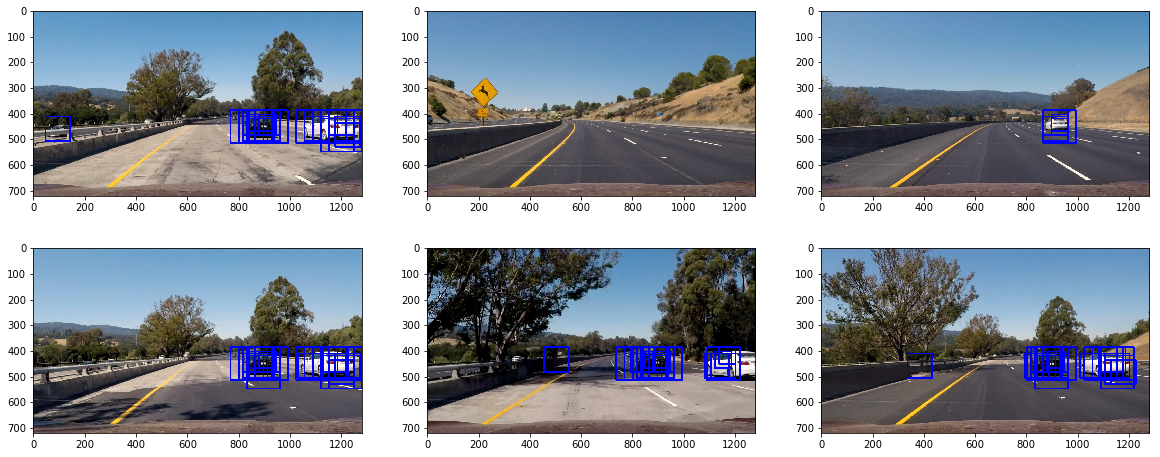

In [8]:
##### use different size windows
fig = plt.figure()
for i in range(1,7):
    image_file = "test_images/test" + str(i) + ".jpg"
    image = mpimg.imread(image_file)
    draw_image = np.copy(image)
    # this is for png
    image = image.astype(np.float32)/255

    # use 3 different size windows.
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[386,656], 
                xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[386,656], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[386,496], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YUV',spatial_size=(16, 16), 
                   hist_bins=16, orient=11, pix_per_cell=16, cell_per_block=2)                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    fig.add_subplot(2,3,i)
    plt.imshow(window_img)

/home/yuanzhou/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


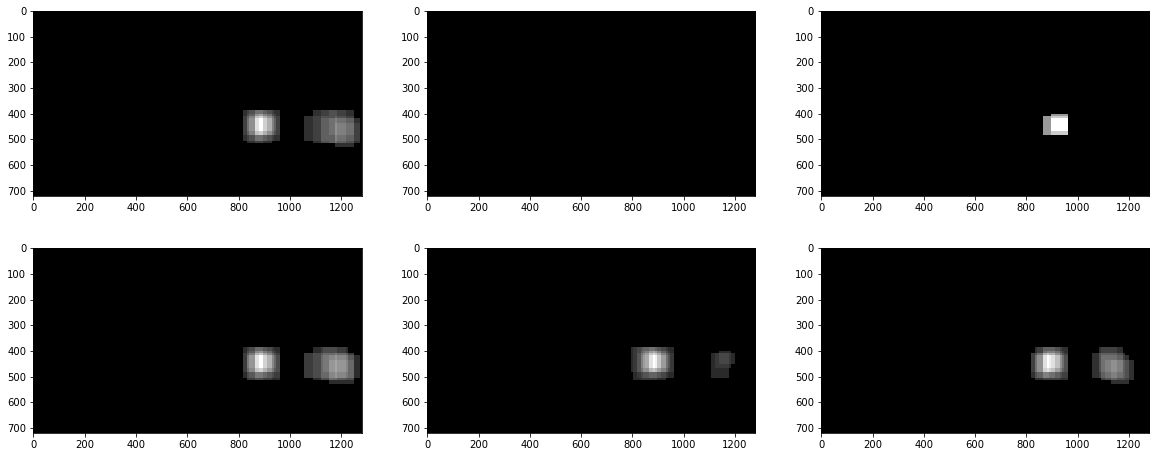

In [9]:
##### use heat-map 
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

fig = plt.figure()
for i in range(1,7):
    image_file = "test_images/test" + str(i) + ".jpg"
    image = mpimg.imread(image_file)
    draw_image = np.copy(image)
    
    # this is for png
    image = image.astype(np.float32)/255

    # choose region of interest
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[386,656], 
                xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[386,656], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[386,496], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YUV',spatial_size=(16, 16), 
                   hist_bins=16, orient=11, pix_per_cell=16, cell_per_block=2)      
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,2)
    heatmap = np.clip(heat, 0, 255)
    fig.add_subplot(2,3,i)
    plt.imshow(heatmap, cmap='gray')

/home/yuanzhou/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


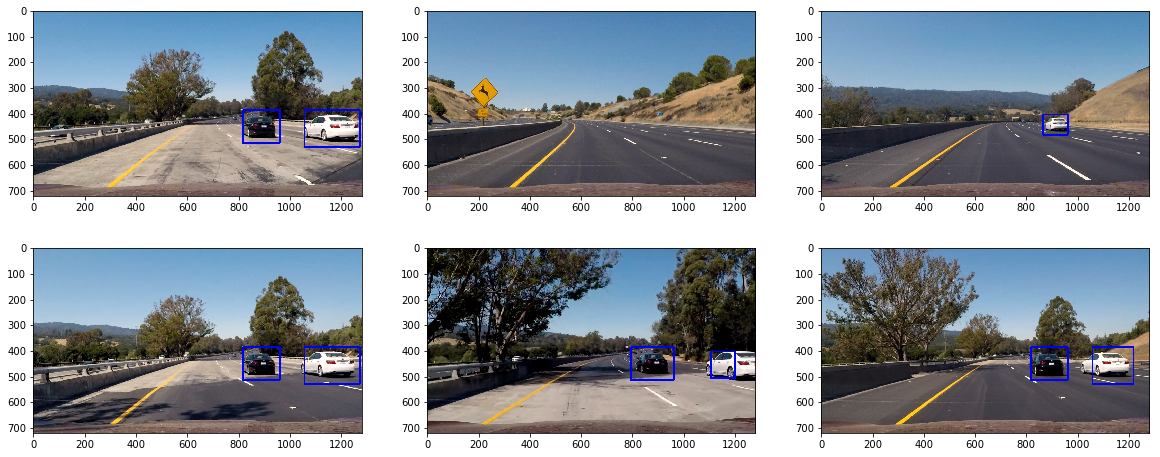

In [10]:
fig = plt.figure()
for i in range(1,7):
    image_file = "test_images/test" + str(i) + ".jpg"
    image = mpimg.imread(image_file)
    draw_image = np.copy(image)
    
    # this is for png
    image = image.astype(np.float32)/255

    # choose region of interest
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[386,656], 
                xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[386,656], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[386,496], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YUV',spatial_size=(16, 16), 
                   hist_bins=16, orient=11, pix_per_cell=16, cell_per_block=2)      
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,2)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    fig.add_subplot(2,3,i)
    plt.imshow(draw_img)

/home/yuanzhou/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


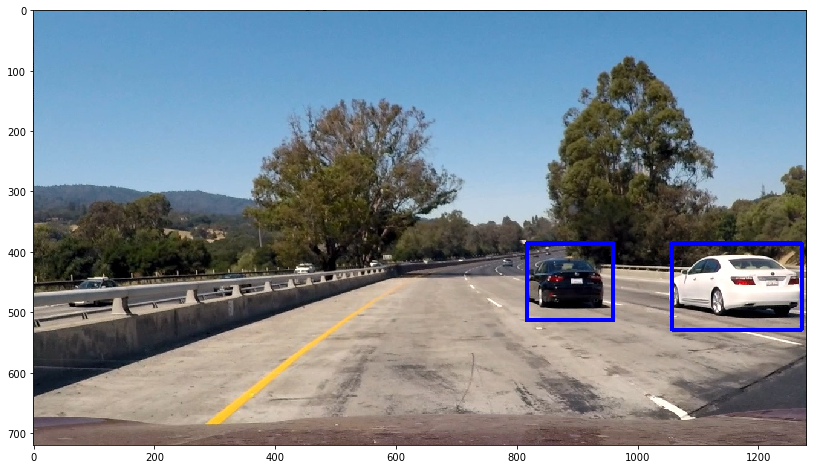

In [11]:
##### pipeline for video, average previous frame heatmap to avoid jumping-around bbox.
from collections import deque

history = deque(maxlen=7)

def image_pipeline(image):
    global history
    
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[386,656], 
                xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[386,656], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows = windows + slide_window(image, x_start_stop=[None, None], y_start_stop=[386,496], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YUV',spatial_size=(16, 16), 
                   hist_bins=16, orient=11, pix_per_cell=16, cell_per_block=2)   
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,2)
    
    
    if len(history) == 7:
        # use average heatmap of previous frames
        current_heat = (heat+history[0]+history[1]+history[2]+history[3]+history[4]+history[5]+history[6])/8
        current_heat = apply_threshold(current_heat, 2)
    else:
        current_heat = heat
        
    history.append(heat)
    
    heatmap = np.clip(current_heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)

    return draw_img

image = mpimg.imread('test_images/test1.jpg')
#image = image.astype(np.float32)/255
newimage = image_pipeline(image)
plt.imshow(newimage)

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [14]:
history = deque(maxlen=7)
output = 'output_test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(19,25)
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|█████████▋| 38/39 [01:09<00:01,  1.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

CPU times: user 1min 9s, sys: 56 ms, total: 1min 9s
Wall time: 1min 10s


In [15]:
history = deque(maxlen=7)
output = 'output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(11,15)
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [38:43<00:01,  1.84s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 38min 37s, sys: 1.72 s, total: 38min 39s
Wall time: 38min 43s
